In [1]:
import sys,os,copy,glob
import numpy as np
sys.path.append(os.path.abspath('../smodels'))
sys.path.append(os.path.abspath('../'))
from builder.protomodel import ProtoModel
from builder.manipulator import Manipulator
from tester.predictor import Predictor
from tester.combiner import Combiner
from walker.hiscore import Hiscore
from smodels.experiment.databaseObj import Database
from smodels.tools import runtime
from smodels.tools.physicsUnits import fb
runtime._experimental = True
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from names import particleLabels
from sparticleNames import SParticleNames
# sns.set() #Set style
# sns.set_style('ticks')
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
# sns.set_palette(sns.color_palette("Paired"))
sns.set_palette(sns.color_palette("deep"))
from smodels.tools import smodelsLogging
smodelsLogging.setLogLevel('error')

In [2]:
#Set colors:
namer = SParticleNames ( susy = False )
#Replace default colors:
colorPalette = 'deep' #Set color palette for particles, if None use default
colorDict = dict(zip(namer.names.keys(),sns.color_palette(palette=colorPalette,n_colors=len(namer.names))))

In [3]:
def getLikelihoods(protomodel,muvals,normalize=True):
    
    #Sort tpList
    critic = sorted(protomodel.tpList, key = lambda tp: tp[0], reverse = True)[0][2]

    #Combiner likelihood:
    combiner = Combiner(0)
    llhComb = np.array([combiner.getCombinedLikelihood(protomodel.bestCombo,mu) for mu in muvals])
    llhCombSM = combiner.getCombinedLikelihood(protomodel.bestCombo,0.)
    llhDict = {'Combined' : llhComb}
    llhDictSM = {'Combined' : llhCombSM}
    for tp in protomodel.bestCombo:
        llhDict[tp.expResult.globalInfo.id] = np.array([tp.getLikelihood(mu) for mu in muvals])
        llhDictSM[tp.expResult.globalInfo.id] = tp.getLikelihood(0.0)

    #Critic likelihood:
    if critic.getLikelihood(1.0) is not None:
        llhDictSM['Critic'] = critic.getLikelihood(0.0)
        llhDict['Critic'] = np.array([critic.getLikelihood(mu) for mu in muvals])
    else:
        llhDict['Critic'] = None
        llhDictSM['Critic'] = None
    llhDict['SM values'] = llhDictSM
    
    #Compute normalizations:
    if normalize:
        for key,llhd in llhDict.items():
            if key != 'SM values':
                norm = llhd.sum()
                llhDict[key] = llhd/norm
                llhDict['SM values'][key] *= 1/norm
    
    
    return llhDict


In [4]:
def fromDict(inputDict):
    
    p = ProtoModel(walkerid=0)
    for key,v in inputDict.items():
        setattr(p,key,copy.deepcopy(v))
        
    return p

In [5]:
#Get highest score from each run:
protomodelsDict = {}
for ff in glob.glob('../data/real9.dict'):
    with open(ff,'r') as f:
        pList = eval(f.read())
    run = eval(os.path.basename(ff).replace('real','').replace('.dict',''))
    pList = [fromDict(pDict) for pDict in pList[:]]
    p = sorted(pList, key = lambda p: p.K, reverse=True)[0]
    protomodelsDict[run] = p  

In [6]:
for run in sorted(protomodelsDict.keys()):
    print(run,protomodelsDict[run])
    
Kavg = np.array([p.K for p in protomodelsDict.values()]).mean()
Kstd = np.array([p.K for p in protomodelsDict.values()]).std()
print('K (avg) = %1.2f +- %1.2f' %(Kavg,Kstd))

9 ProtoModel (XZ1,Xd,Xt): K = 6.90, Z = 3.24
K (avg) = 6.90 +- 0.00


In [7]:
protomodel = protomodelsDict[9]
for pids, ssm in protomodel.ssmultipliers.items():
    if not ssm: continue
    print(pids,ssm)
print(protomodel.masses)    

(1000022, 1000022) 0.003
(1000001, 1000001) 0.493
(-1000001, 1000001) 0.492
(-1000001, -1000001) 0.493
(1000001, 1000022) 0.493
(-1000001, 1000022) 0.493
(1000006, 1000006) 1.325
(-1000006, 1000006) 1.226
(-1000006, -1000006) 1.11
(1000006, 1000022) 1.226
(-1000006, 1000022) 1.11
(1000001, 1000006) 1.11
(-1000006, 1000001) 1.11
(-1000001, 1000006) 1.11
(-1000006, -1000001) 1.11
{1000022: 162.552, 1000001: 734.948, 1000006: 1165.865}


In [8]:
run = 9
p = protomodelsDict[run]
mXt = np.linspace(700.,900.,20)
pList = []
pred = Predictor(walkerid=0,dbpath='../official124_smodels200.pcl')
for mass in mXt:
    protomodel = copy.deepcopy(p)
    protomodel.masses[1000006] = mass
    #Get predictions:
    res = pred.predict(protomodel)
    pList.append(protomodel)
    print(mass,protomodel.K)

[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:01:00


700.0 0.05884287162443824
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:54


710.5263157894736 0.072024921384501
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:49


721.0526315789474 0.06154665449598884
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:46


731.578947368421 0.039134914708914614
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:58


742.1052631578948 0.014943548060625922
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:58


752.6315789473684 -0.011088019434526863
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:40


763.1578947368421 -0.06208972961799253
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:45


773.6842105263158 -0.08242201776176916
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:44


784.2105263157895 -0.07089834883564361
[combine:0] selected predictions down via SRs from 286 to 22.


[combine:0] sorting out subsets, reduced 6025 -> 432 combinations.


combination #432/432 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:51


794.7368421052631 -0.08357773588207618


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:18


805.2631578947369 -0.45240487461412204


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:19


815.7894736842105 -0.41533275660352853


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:18


826.3157894736842 -0.32322879993329234


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:14


836.8421052631579 -0.2358432116673268


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:18


847.3684210526316 0.014116680425471095


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:16


857.8947368421052 0.2582932526195072


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:16


868.421052631579 0.44481878748331827


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:15


878.9473684210527 0.5908204262014225


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


combination #216/216 100%|||||||||||||||||||||||||||||||||||||||||Time: 0:00:16


889.4736842105264 0.9154830462867078


[combine:0] selected predictions down via SRs from 242 to 18.
[combine:0] sorting out subsets, reduced 1493 -> 216 combinations.


900.0 1.1181675589789561


In [9]:
kvalues = [pp.K for pp in pList]

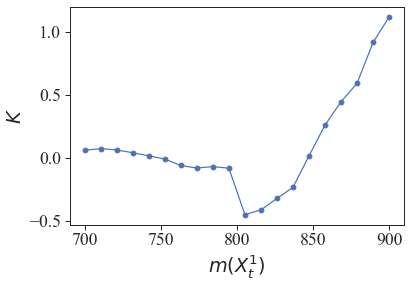

In [10]:
plt.plot(mXt,kvalues,'o-')
plt.xlabel(r'$m(X_t^1)$')
plt.ylabel(r'$K$')
plt.savefig('KvsMXt.png')
plt.show()

In [11]:
run = 9
p = protomodelsDict[run]
mZ = np.linspace(450.,600.,30)
pList2 = []
pred = Predictor(walkerid=0,dbpath='../official124_smodels200.pcl')
for mass in mZ:
    protomodel = copy.deepcopy(p)
    protomodel.masses[1000022] = mass
    #Get predictions:
    res = pred.predict(protomodel)
    pList2.append(protomodel)

[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:06


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 208 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:07


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:06


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:05


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:08


[combine:0] selected predictions down via SRs from 206 to 15.
[combine:0] sorting out subsets, reduced 512 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:06


[combine:0] selected predictions down via SRs from 204 to 14.
[combine:0] sorting out subsets, reduced 249 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:06


[combine:0] selected predictions down via SRs from 204 to 14.
[combine:0] sorting out subsets, reduced 249 -> 42 combinations.


combination #42/42 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 202 to 13.
[combine:0] sorting out subsets, reduced 184 -> 28 combinations.


combination #28/28 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


[combine:0] selected predictions down via SRs from 202 to 13.
[combine:0] sorting out subsets, reduced 184 -> 28 combinations.


combination #28/28 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


[combine:0] selected predictions down via SRs from 204 to 13.
[combine:0] sorting out subsets, reduced 184 -> 28 combinations.


combination #28/28 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


[combine:0] selected predictions down via SRs from 204 to 13.
[combine:0] sorting out subsets, reduced 184 -> 28 combinations.


combination #28/28 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:02


[combine:0] selected predictions down via SRs from 204 to 13.
[combine:0] sorting out subsets, reduced 220 -> 32 combinations.


combination #32/32 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:04


[combine:0] selected predictions down via SRs from 204 to 13.
[combine:0] sorting out subsets, reduced 220 -> 32 combinations.


combination #32/32 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:03


[combine:0] selected predictions down via SRs from 190 to 12.
[combine:0] sorting out subsets, reduced 143 -> 16 combinations.


combination #16/16 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


[combine:0] selected predictions down via SRs from 190 to 12.
[combine:0] sorting out subsets, reduced 143 -> 16 combinations.


combination #16/16 100%|||||||||||||||||||||||||||||||||||||||||||Time: 0:00:01


In [12]:
kvalues2 = [pp.K for pp in pList2]

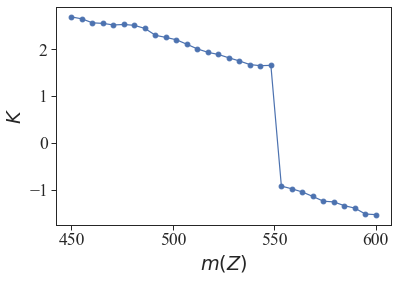

In [13]:
plt.plot(mZ,kvalues2,'o-')
plt.xlabel(r'$m(Z)$')
plt.ylabel(r'$K$')
plt.savefig('KvsMZ.png')
plt.show()